# 📨 Spam Email Classifier (SEC)


In [81]:
import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Downloading the dataset

In [19]:
outpout_dir = 'data'
os.makedirs(outpout_dir, exist_ok=True)

url = "https://drive.google.com/file/d/1wtogytIpZC74Tq6s1GWaPWY3VBhmOrJy/view?usp=sharing"
output = "data/spam_emails_1.csv"

gdown.download(url, output, quiet=False , fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1wtogytIpZC74Tq6s1GWaPWY3VBhmOrJy
To: /app/src/data/spam_emails_1.csv
100%|██████████| 5.50M/5.50M [00:00<00:00, 39.5MB/s]


'data/spam_emails_1.csv'

## Data Exploration

In [70]:
df = pd.read_csv('data/spam_emails_1.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [71]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('label_num', axis=1, inplace=True)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [72]:
label = {'ham': 0, 'spam': 1}
df['label'] = df['label'].map(label)
df.head()

,label,text
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


Text(0.5, 1.0, 'Number of ham and spam messages')

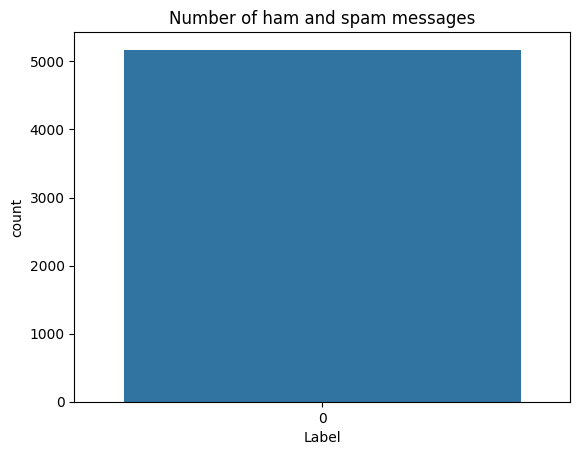

In [73]:
# bar plot label value counts  0 = non-spam, 1 = spam=
sns.countplot(df['label'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

## Preprocessing

In [76]:
# remove punctuation
df['text'] = df['text'].str.replace('[^\w\s]','')
df.head()

/tmp/ipykernel_15319/2903461620.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')


,label,text
0,0,Subject enron methanol meter 988291\r\nthis...
1,0,Subject hpl nom for january 9 2001\r\n see at...
2,0,Subject neon retreat\r\nho ho ho we re aroun...
3,1,Subject photoshop windows office cheap mai...
4,0,Subject re indian springs\r\nthis deal is to ...


In [77]:
# convert to lowercase
df['text'] = df['text'].str.lower()
df.head()

,label,text
0,0,subject enron methanol meter 988291\r\nthis...
1,0,subject hpl nom for january 9 2001\r\n see at...
2,0,subject neon retreat\r\nho ho ho we re aroun...
3,1,subject photoshop windows office cheap mai...
4,0,subject re indian springs\r\nthis deal is to ...


In [80]:
# remove stopwords

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,0,subject enron methanol meter 988291 follow not...
1,0,subject hpl nom january 9 2001 see attached fi...
2,0,subject neon retreat ho ho ho around wonderful...
3,1,subject photoshop windows office cheap main tr...
4,0,subject indian springs deal book teco pvr reve...
